# $$Model \ Inversion \  Attack - MNIST - ANN - Fredrikson$$

---



# Necessary Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torch.nn.functional as F
from tqdm import tqdm
import os
from PIL import Image
import zipfile

**Read Me**

You may need to upload the following files through the code for more convenience:

- ***MNIST_ANN_Weights_Target*** : The pre-trained parameters for the target model
- ***MNIST_ANN_Weights_Eval*** : The pre-trained parameters for the evaluation classifier
- ***MNIST_ANN_Inverted*** : All the inverted samples extracted from the target model


# Data Preparation - MNIST

In [2]:
# Data
data_path='/data/mnist'

# Define a transform
transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(data_path, train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 38070973.56it/s]


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6725650.65it/s]


Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 51846373.07it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 9829994.20it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [3]:
train_loader = DataLoader(mnist_train, batch_size=1000, shuffle=True, drop_last=True)
test_loader  = DataLoader(mnist_test, batch_size=1000, shuffle=True, drop_last=True)

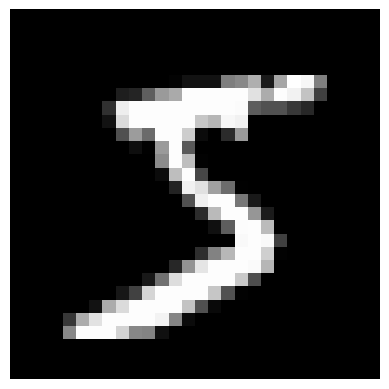

In [ ]:
# Show an example of the MNIST data
plt.imshow(mnist_train[0][0].squeeze(),cmap='gray')
plt.axis('off')
plt.show()

# Network Model and Training

In [4]:
# Network Architecture Parameters
num_inputs= 28*28
num_hidden = 3000
num_outputs = 10

# Data Type and Device
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Define Network
class MLP_Net(nn.Module):
    def __init__(self):
        super(MLP_Net, self).__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):

        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

MLP = MLP_Net().to(device)

The state dictionary containing the pre-trained model's learned parameters is saved in **'MNIST_ANN_Weights_Target'** and can be loaded by running the following cell.

In [35]:
MLP.load_state_dict(torch.load("MNIST_ANN_Weights_Target",map_location=device))

<All keys matched successfully>

Following cell contains the training loop. If you have already loaded learned parameters, you don't need to run this cell. (You may run this just for one epoch to check the model and the accuracy)

In [6]:
# MLP

# Define loss function (CrossEntropyLoss) and optimizer (Adam)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(MLP.parameters(), lr=1e-3, betas=(0.9, 0.999))



# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    MLP.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = MLP(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluation
MLP.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = MLP(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")


with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = MLP(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Train Accuracy: {accuracy}%")

Epoch 1/50, Loss: 0.9755436499913533
Epoch 2/50, Loss: 0.37500459849834444
Epoch 3/50, Loss: 0.30997543086608254
Epoch 4/50, Loss: 0.28170235902071
Epoch 5/50, Loss: 0.2651555525759856
Epoch 6/50, Loss: 0.24959197839101155
Epoch 7/50, Loss: 0.23224643195668856
Epoch 8/50, Loss: 0.2173206460972627
Epoch 9/50, Loss: 0.20254311511913936
Epoch 10/50, Loss: 0.1890535570681095
Epoch 11/50, Loss: 0.17784983466068904
Epoch 12/50, Loss: 0.1625026799738407
Epoch 13/50, Loss: 0.1519871080915133
Epoch 14/50, Loss: 0.14138248078525067
Epoch 15/50, Loss: 0.1313922411451737
Epoch 16/50, Loss: 0.12250136025249958
Epoch 17/50, Loss: 0.1143123476455609
Epoch 18/50, Loss: 0.10820859546462695
Epoch 19/50, Loss: 0.10155259805421034
Epoch 20/50, Loss: 0.09351713694632054
Epoch 21/50, Loss: 0.08891147468239069
Epoch 22/50, Loss: 0.08253560401499271
Epoch 23/50, Loss: 0.07726673992971579
Epoch 24/50, Loss: 0.07288465710977714
Epoch 25/50, Loss: 0.06861808784306049
Epoch 26/50, Loss: 0.06479376802841823
Epoch 

In [7]:
# torch.save(MLP.state_dict(),"MNIST_ANN_Weights_Target")

# MI Attack

Reconstruction of one target classe:

Target Class:3


  2%|▏         | 96/5000 [00:00<00:30, 161.05it/s]


Terminating due to cost below threshold in iteration:  96

 Confidence Score:  0.9905401468276978


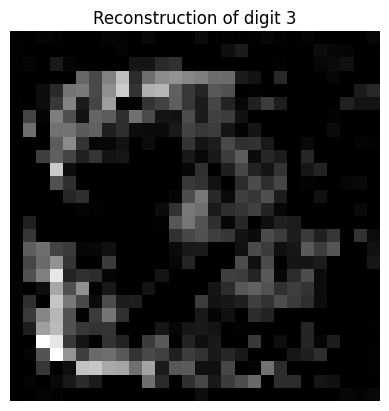

In [ ]:
# Initialize some variables
target = int(input('Target Class:')) # Specify your target class
MLP.to('cpu')
ini = torch.zeros((1, 28*28))  # Initialize ini with starting value

beta = 100  # Set the value of beta (the number of consecutive iterations without improvement)
consecutive_no_improvement = 0
gamma = 0.01  # Set the threshold value gamma
current_cost = float('inf')  # Initialize with positive infinity

for i in tqdm(range(5000)):
    ini.requires_grad_()

    cost = 1 - F.softmax(MLP(ini), dim=1)[0][target]

    # Compute the gradient
    cost.backward()

    with torch.no_grad():
        ini -= 0.1 * ini.grad
        ini = torch.clamp(ini,0,1)

    # Check if cost has not improved for beta iterations
    if cost >= current_cost:
        consecutive_no_improvement += 1
    else:
        consecutive_no_improvement = 0

    if consecutive_no_improvement >= beta:
        print("Terminating due to no improvement for in iteration: ", i)
        break

    # Check if cost is below the threshold gamma
    if cost <= gamma:
        print("Terminating due to cost below threshold in iteration: ", i)
        break

    # Update the current_cost
    current_cost = cost

print("\n Confidence Score: ",F.softmax(MLP(ini), dim=1)[0][target].item())


plt.imshow(ini.view(28, 28).detach(), cmap='gray')
plt.title(f'Reconstruction of digit {target}')
plt.axis('off')


plt.show()



Reconstruction of all classes:

**NOTE:** The inverted samples are stored in **"MNIST_ANN_Inverted"** and can be loaded by uncommenting the following command. Alternatively, they can be regenerated by running the next cell.

In [36]:
# ini_tensors_MLP = torch.load('MNIST_ANN_Inverted',map_location=device)

In [49]:
## FOR MLP

MLP.to('cpu')

ini_list = []  # List to save 'ini' tensors
cost_list = []  # List to save cost values


for target in range(10):


  ini = torch.zeros((1, 28*28))  # Initialize ini with starting value
  beta = 100  # Set the value of beta (the number of consecutive iterations without improvement)
  consecutive_no_improvement = 0
  gamma = 0.01  # Set the threshold value gamma
  current_cost = float('inf')  # Initialize with positive infinity

  for i in tqdm(range(5000)):
      ini.requires_grad_()

      cost = 1 - F.softmax(MLP(ini), dim=1)[0][target]

      # Compute the gradient
      cost.backward()

      with torch.no_grad():
          ini -= 0.1 * ini.grad
          ini = torch.clamp(ini,0,1)

      # Check if cost has not improved for beta iterations
      if cost >= current_cost:
          consecutive_no_improvement += 1
      else:
          consecutive_no_improvement = 0

      if consecutive_no_improvement >= beta:
          print("Terminating due to no improvement for in iteration: ", i)
          break

      # Check if cost is below the threshold gamma
      if cost <= gamma:
          print("Terminating due to cost below threshold in iteration: ", i)
          break

      # Update the current_cost
      current_cost = cost


  # Save 'ini' tensor and cost value for this target
  ini_list.append(ini.detach().numpy())  # Convert to NumPy for saving
  cost_list.append(F.softmax(MLP(ini), dim=1)[0][target].item())
  print(cost)

# Convert the lists to tensors
ini_tensors_MLP = torch.tensor(ini_list)
cost_tensors_MLP = torch.tensor(cost_list)

 18%|█▊        | 891/5000 [00:07<00:36, 113.06it/s]


Terminating due to cost below threshold in iteration:  891
tensor(0.0099, grad_fn=<RsubBackward1>)


  1%|          | 58/5000 [00:00<00:32, 151.61it/s]


Terminating due to cost below threshold in iteration:  58
tensor(0.0098, grad_fn=<RsubBackward1>)


  0%|          | 25/5000 [00:00<00:33, 147.28it/s]


Terminating due to cost below threshold in iteration:  25
tensor(0.0094, grad_fn=<RsubBackward1>)


  2%|▏         | 96/5000 [00:00<00:33, 147.23it/s]


Terminating due to cost below threshold in iteration:  96
tensor(0.0098, grad_fn=<RsubBackward1>)


  2%|▏         | 79/5000 [00:00<00:31, 156.87it/s]


Terminating due to cost below threshold in iteration:  79
tensor(0.0098, grad_fn=<RsubBackward1>)


  0%|          | 14/5000 [00:00<00:24, 205.92it/s]


Terminating due to cost below threshold in iteration:  14
tensor(0.0096, grad_fn=<RsubBackward1>)


  1%|          | 52/5000 [00:00<00:25, 197.82it/s]


Terminating due to cost below threshold in iteration:  52
tensor(0.0098, grad_fn=<RsubBackward1>)


  0%|          | 16/5000 [00:00<00:26, 185.27it/s]


Terminating due to cost below threshold in iteration:  16
tensor(0.0096, grad_fn=<RsubBackward1>)


 58%|█████▊    | 2893/5000 [00:18<00:13, 156.86it/s]


Terminating due to cost below threshold in iteration:  2893
tensor(0.0100, grad_fn=<RsubBackward1>)


  1%|▏         | 64/5000 [00:00<00:27, 180.77it/s]

Terminating due to cost below threshold in iteration:  64
tensor(0.0100, grad_fn=<RsubBackward1>)


In [9]:
# torch.save(ini_tensors_MLP,'MNIST_ANN_Inverted')

# Attack Evaluation

## Visual Inspection

The inverted samples are stored in **"MNIST_ANN_Inverted"** and will be loaded at the first line (commented) of the following cell. Alternatively, they can be regenerated by running the previos section.

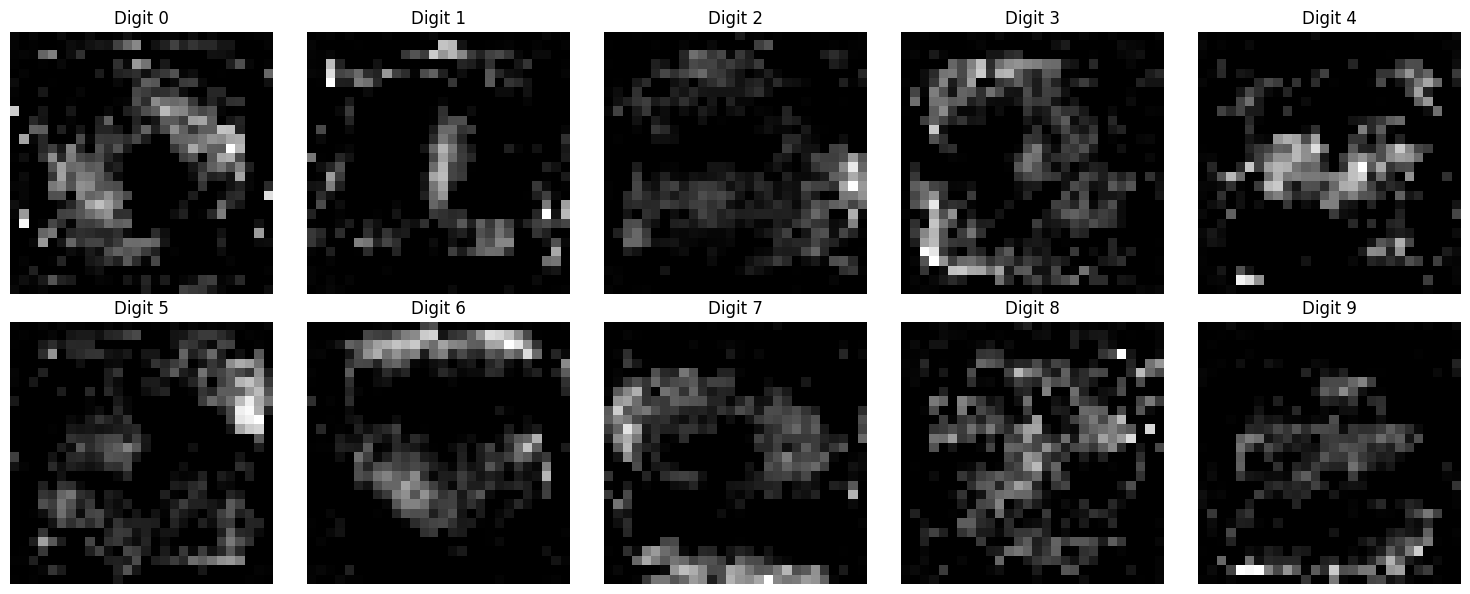

In [50]:
# ini_tensors_MLP = torch.load('MNIST_ANN_Inverted',map_location=device)  # Uncomment this line to load the inverted samples

# Reshape the tensor to [10, 28, 28] assuming the images are 28x28 pixels
ini_tensors_reshaped = ini_tensors_MLP.view(10, 28, 28).cpu().numpy()

# Create a grid for plotting
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns for 10 images

# Plot each image in the grid
for i in range(10):
    row, col = divmod(i, 5)  # Calculate the row and column index
    ax = axes[row, col]
    ax.imshow(ini_tensors_reshaped[i], cmap='gray')  # Assuming grayscale images
    ax.axis('off')  # Turn off axis labels
    ax.set_title(f'Digit {i}')

# Adjust layout for better appearance
plt.tight_layout()

# Show the grid figure
plt.show()

## Evaluation Classifier

In [39]:
# Define Network
class Eval_Net(nn.Module):
    def __init__(self):
        super(Eval_Net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5)  # 1 input channel (assuming grayscale image)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)  # 12 input channels from previous layer

        # Fully connected layers
        self.fc1 = nn.Linear(24 * 4 * 4, 10)  # 24 channels, 4x4 image dimension after pooling
        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, x):
        # Apply convolutional and pooling layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten the output for dense layers
        x = x.view(-1, 24 * 4 * 4)  # Flatten to 1D (24 channels, 4x4 image dimension after pooling)

        # Fully connected layers
        x = self.fc1(x)

        return x

eval_net = Eval_Net().to(device)
eval_net.parameters

<bound method Module.parameters of Eval_Net(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=384, out_features=10, bias=True)
  (relu): ReLU()
)>

The state dictionary containing the pre-trained model's learned parameters is saved in **'MNIST_ANN_Weights_Eval'** and can be loaded by running the following cell.

In [66]:
eval_net.load_state_dict(torch.load("MNIST_ANN_Weights_Eval",map_location=device))

<All keys matched successfully>

Following cell contains the training loop. If you have already loaded learned parameters, you don't need to run this cell. (You may run it for just one epoch to check the model and its accuracy)

In [12]:
# Define loss function (e.g., CrossEntropyLoss) and optimizer (e.g., Adam)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(eval_net.parameters(), lr=0.001)



# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    eval_net.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = eval_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluation
eval_net.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = eval_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")


with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = eval_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Train Accuracy: {accuracy}%")

Epoch 1/20, Loss: 1.1504535734653474
Epoch 2/20, Loss: 0.265422622859478
Epoch 3/20, Loss: 0.17433028072118759
Epoch 4/20, Loss: 0.1355358040581147
Epoch 5/20, Loss: 0.11415538378059864
Epoch 6/20, Loss: 0.096922944051524
Epoch 7/20, Loss: 0.08649809987594684
Epoch 8/20, Loss: 0.07808952561269204
Epoch 9/20, Loss: 0.0731060590595007
Epoch 10/20, Loss: 0.06690757603694995
Epoch 11/20, Loss: 0.0631442998846372
Epoch 12/20, Loss: 0.05918297814205289
Epoch 13/20, Loss: 0.05520040479799112
Epoch 14/20, Loss: 0.052866080620636545
Epoch 15/20, Loss: 0.05266558409978946
Epoch 16/20, Loss: 0.04938524089132746
Epoch 17/20, Loss: 0.045729633700102565
Epoch 18/20, Loss: 0.04349327820042769
Epoch 19/20, Loss: 0.04220242587228616
Epoch 20/20, Loss: 0.04071963503956795
Test Accuracy: 98.69%
Train Accuracy: 98.85428571428571%


In [ ]:
# torch.save(eval_net.state_dict(),'MNIST_ANN_Weights_Eval')

Here we define two useful functions for future use:

In [13]:
# Function for calculating the accuracy and top-3 accuracy
def count_correct(lst):
    first = 0
    top_3 = 0

    for num in lst:
        # Count the number of occurrences of digit 1
        if num == 1:
          first += 1

        # Count the number of values between 2 and 3 (inclusive)
        if 2 <= num <= 3:
            top_3 += 1

    return first, top_3+first

# Function to scale a tensor values between 0 and 1
def Scale(x):
  return (x - x.min())/(x.max()-x.min())

The inverted samples are stored in **"MNIST_ANN_Inverted"** and will be loaded at the first line of the following cell. Alternatively, they can be regenerated by running the inversion attack section.

In [45]:
ini_tensors_MLP = torch.load("MNIST_ANN_Inverted").view(10,1,28,28).to(device)
MLP.to(device) # Better safe than sorry!

MLP_Net(
  (fc1): Linear(in_features=784, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=10, bias=True)
)

In [67]:
# Scale the inputs
scaled_input = torch.zeros(10,1,28,28).to(device)
for i in range(10):
  scaled_input[i] = Scale(ini_tensors_MLP.view(10,1,28,28).to(device)[i])

conf_mat = F.softmax(eval_net(scaled_input),dim=1).detach() # Confidence Matrix
rank_mat = torch.argsort(conf_mat,descending=True) # Ranking Matrix
conf_ranks=[]


for i in range(10):
   conf_ranks.append(torch.where(rank_mat[i]==i)[0].item()+1)

DAA_ranks = conf_mat.argmax(0) # Out of all inverted samples, which one is the most similar to digit X

print("\n ** Predicted Labels  :\n\n",conf_mat.max(1)[1])
print("\n\n ** Predicted Labels Confidence  :\n\n",conf_mat.max(1)[0])

print("\n\n\n ** Ground Truth Ranks in Prediction  :\n\n",conf_ranks)
print("\n\n\n ** Number of corrects (First,Top-3)  :\n\n",count_correct(conf_ranks))

print("\n\n ** Confidences of the correct outputs  :\n\n",torch.diag(conf_mat))

print("\n\n ** DAA Ranks  :\n\n",DAA_ranks) # Out of all inverted samples, which one is the most similar to digit X


 ** Predicted Labels  :

 tensor([0, 1, 2, 2, 2, 5, 2, 0, 8, 3], device='cuda:0')


 ** Predicted Labels Confidence  :

 tensor([0.7918, 0.3757, 0.7920, 0.4985, 0.4444, 0.8069, 0.7304, 0.2939, 0.6905,
        0.3067], device='cuda:0')



 ** Ground Truth Ranks in Prediction  :

 [1, 1, 1, 2, 2, 1, 2, 5, 1, 3]



 ** Number of corrects (First,Top-3)  :

 (5, 9)


 ** Confidences of the correct outputs  :

 tensor([0.7918, 0.3757, 0.7920, 0.3518, 0.3787, 0.8069, 0.1077, 0.1023, 0.6905,
        0.1403], device='cuda:0')


 ** DAA Ranks  :

 tensor([0, 1, 2, 3, 4, 5, 6, 9, 8, 1], device='cuda:0')


Summary of the metrics:

In [68]:
print("Attack Accracy:",count_correct(conf_ranks)[0]/10)
print("\n\nTop-3 Attack Accuracy:", count_correct(conf_ranks)[1]/10)
print("\n\nAverage Confidence",torch.diag(conf_mat).mean().item()) # Average Confidence of correct outputs
print("\n\nDAA:", (sum(DAA_ranks==torch.tensor(range(10)).to(device)).item())/10)

Attack Accracy: 0.5


Top-3 Attack Accuracy: 0.9


Average Confidence 0.45378097891807556


DAA: 0.8
